<a href="https://colab.research.google.com/github/pri538/SQL-Projects/blob/main/Mental_Health_SQL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

#Insert path here
path = "/content/mental_health.sqlite"
con = sql.connect(path)

In [ ]:
con

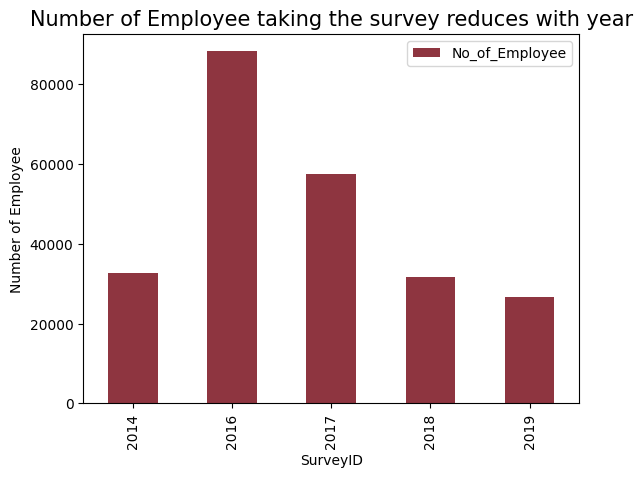

In [ ]:
query = """
    SELECT
        SurveyID,
        COUNT() AS No_of_Employee
    FROM Answer
    GROUP BY SurveyID;
"""

Employee_per_survey = pd.read_sql(query, con).astype({"No_of_Employee": int})

barplot = Employee_per_survey.plot.bar(x='SurveyID',y='No_of_Employee', color = '#7A111E', alpha = 0.85)
plt.title('Number of Employee taking the survey reduces with year', fontsize = 15)
plt.ylabel('Number of Employee')
plt.xlabel('SurveyID')
plt.show()

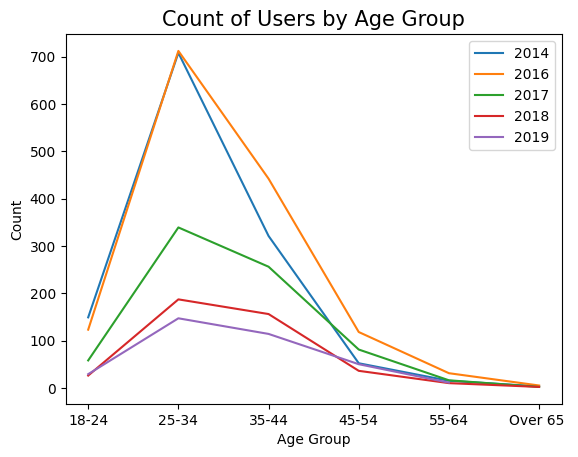

In [ ]:
query = """

SELECT SurveyID,
       CASE
            WHEN AnswerText BETWEEN 18 AND 24 THEN '18-24'
            WHEN AnswerText BETWEEN 25 AND 34 THEN '25-34'
            WHEN AnswerText BETWEEN 35 AND 44 THEN '35-44'
            WHEN AnswerText BETWEEN 45 AND 54 THEN '45-54'
            WHEN AnswerText BETWEEN 55 AND 64 THEN '55-64'
            WHEN AnswerText BETWEEN 65 AND 99 THEN 'Over 65 '
        END AS age_group,
    COUNT(*) AS count
FROM Answer
WHERE SurveyID IN (2014, 2016, 2017, 2018, 2019)
      AND QuestionID=1
      AND AnswerText > 18

GROUP BY SurveyID, age_group
ORDER BY SurveyID, age_group;
"""

Age_Survey = pd.read_sql(query, con)
# Get a list of unique age groups in the dataframe
SurveyID_groups = Age_Survey['SurveyID'].unique()

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each age group
for SurveyID_group in SurveyID_groups:
    ax.plot(Age_Survey.loc[Age_Survey['SurveyID'] == SurveyID_group, 'age_group'], Age_Survey.loc[Age_Survey['SurveyID'] == SurveyID_group, 'count'], label=SurveyID_group)

# Set the x and y axis labels
ax.set_xlabel('Age Group')
ax.set_ylabel('Count')

# Set the title of the plot
ax.set_title('Count of Users by Age Group',fontsize = 15)

# Show the legend
ax.legend()

# show graph
plt.show()

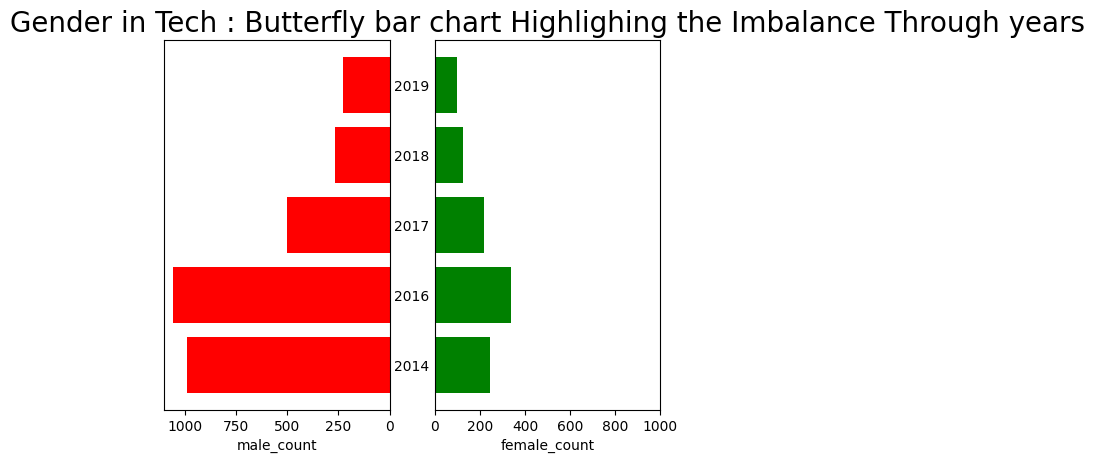

In [ ]:
#Howevevr, because it is a readonly data we can not change text there to account for Country name we need to consider both united states and united states of america together

query = """
SELECT SurveyID,
       SUM(CASE WHEN AnswerText = 'male' OR AnswerText = 'Male' THEN 1 ELSE 0 END) AS male_count,
       SUM(CASE WHEN AnswerText = 'female' OR AnswerText = 'Female'THEN 1 ELSE 0 END) AS female_count
FROM Answer
WHERE     QuestionID == 2
      OR (QuestionID == 9 AND AnswerText == 1 )
      OR (QuestionID == 3 AND AnswerText =='United States of America' OR AnswerText =='United States')
GROUP BY SurveyID
"""

#Question 2: what is your gender?
#Question 9: Is your employer primarily a tech company/organization?
#Question 3: What country do you live in?
df = pd.read_sql(query, con)
position = np.arange(len(df)) + .5
fig, (ax_left, ax_right) = plt.subplots(ncols=2)
ax_left.barh(position, df['male_count'], align = 'center', facecolor='red')
ax_left.set_xlim((0,1100))
ax_left.set_yticks([])
ax_left.invert_xaxis()
ax_left.set_xlabel('male_count')

ax_right.barh(position, df['female_count'], align = 'center', facecolor='green')
ax_right.set_xlim((0,1000))
ax_right.set_yticks(position)
ax_right.set_yticklabels(df['SurveyID'].values, ha = 'center', x = -0.06)
ax_right.set_xlabel('female_count')
plt.title('Gender in Tech : Butterfly bar chart Highlighing the Imbalance Through years', fontsize= 20)
plt.tick_params(left = False)
plt.show()

In [ ]:
#query = """
#SELECT year, state, COUNT(*) As Employee_count
#FROM(
#  SELECT UserID, SurveyID As year,
#  MAX(CASE WHEN QuestionID == 4 THEN AnswerText END) As state,
#  MAX(CASE WHEN (QuestionID == 5 AND AnswerText !=1) THEN AnswerText END) As Self_employee,
#  MAX(CASE WHEN QuestionID == 13 AND AnswerText END) As tech_company,
#  COUNT(*) As count
#FROM Answer
#WHERE QuestionID == 4 AND AnswerText != -1 OR
#      (QuestionID  == 5) OR
#      (QuestionID == 13 And AnswerText == 1)
#GROUP BY UserID
#HAVING state IS NOT NULL
#       AND Self_employee IS NOT NULL
#      AND tech_company IS NOT NULL
#)
#GROUP BY year, state
#ORDER BY year
#"""
#df = pd.read_sql(query, con)

In [ ]:
query = """

SELECT year,company_type,
        COUNT(Mental_Health) AS total_Mental_Health,
        SUM(Mental_Health) AS have_Mental_Health,
        100.0*SUM(Mental_Health)/COUNT(Mental_Health) AS Percentage
FROM (
    SELECT SurveyID AS year,
            MAX(CASE WHEN (QuestionID == 4  AND AnswerText !=-1) THEN AnswerText END) AS state,
            MAX(CASE WHEN (QuestionID == 5  AND AnswerText != 1) THEN AnswerText END) AS Self_Employed,
            MAX(CASE WHEN (QuestionID == 13 AND AnswerText == 1) THEN 'Tech_company' ELSE 'Other_company' END) AS company_type,
            MAX(CASE WHEN (QuestionID == 33 AND AnswerText == 'Yes') THEN 1 ELSE 0 END) AS Mental_Health
    FROM Answer
    WHERE QuestionID IN (4,5,13, 33) AND year != 2014
    GROUP BY year, UserID
    HAVING state IS NOT NULL
       AND Self_Employed IS NOT NULL
) AS mh_data
GROUP BY year,company_type;

"""
df = pd.read_sql(query, con)

#Question 4 which state ? remove -1 (outside USA)
#Question 5 are you self employed
#Question 13 Is your primary role within your company related to tech/IT?
#Question 33 Do you currently have a mental health disorder?

# Create a trace for the bar chart of total mental health
trace1 = go.Bar(
    x=df[df['company_type'] == 'Other_company']['year'],
    y=df[df['company_type'] == 'Other_company']['total_Mental_Health'],
    name='Other Company', marker_color= '#D6604D'
)

trace2 = go.Bar(
    x=df[df['company_type'] == 'Tech_company']['year'],
    y=df[df['company_type'] == 'Tech_company']['total_Mental_Health'],
    name='Tech Company',marker_color= '#4393C3'
)

# Create a trace for the line chart of percentage of users with mental health
trace3 = go.Scatter(
    x=df[df['company_type'] == 'Other_company']['year'],
    y=df[df['company_type'] == 'Other_company']['Percentage'],
    name='Other Company',
    yaxis='y2',marker_color= '#B2182B'
)

trace4 = go.Scatter(
    x=df[df['company_type'] == 'Tech_company']['year'],
    y=df[df['company_type'] == 'Tech_company']['Percentage'],
    name='Tech Company',
    yaxis='y2',marker_color= '#2166AC'
)

# Define the layout
layout = go.Layout(
    title='Mental Health Comparison by role',
    yaxis=dict(title='Total number of employees'),
    yaxis2=dict(
        title='Percentage of Users with Mental Health',
        overlaying='y',
        side='right',
        range=[0, 100]
    ),
    barmode='group'
)

# Combine the traces and layout into a figure
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)

# Show the figure
fig.show()

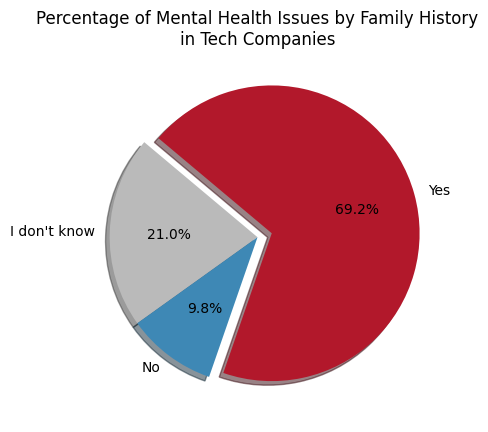

In [ ]:
query = """

SELECT family_history,
       100.0 * COUNT(family_history) / SUM(COUNT(family_history)) OVER () AS percentage
FROM (
    SELECT SurveyID AS year,
            MAX(CASE WHEN (QuestionID == 4  AND AnswerText !=-1) THEN AnswerText END) AS state,
            MAX(CASE WHEN (QuestionID == 5  AND AnswerText != 1) THEN AnswerText END) AS Self_Employed,
            MAX(CASE WHEN (QuestionID == 13 AND AnswerText == 1) THEN 'Tech_company' END) AS tech_company,
            MAX(CASE WHEN (QuestionID == 33 AND AnswerText == 'Yes') THEN 1 END) AS Mental_Health,
            MAX(CASE WHEN (QuestionID == 6 ) THEN AnswerText END) AS family_history

    FROM Answer
    WHERE QuestionID IN (4,5,6, 13, 33) AND year != 2014
    GROUP BY year, UserID
    HAVING state IS NOT NULL
       AND Self_Employed IS NOT NULL
       AND tech_company IS NOT NULL
       AND Mental_Health IS NOT NULL
)
GROUP BY  family_history

"""
df = pd.read_sql(query, con)

colors = ["#BABABA", "#3E88B5", "#B2182B"]
explode = (0, 0, 0.1)
plt.pie(df["percentage"], labels=df["family_history"], explode=explode, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Percentage of Mental Health Issues by Family History\n"+"in Tech Companies")
plt.show()

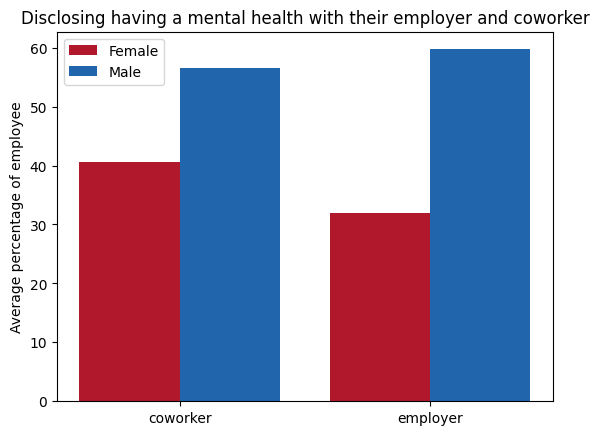

In [ ]:
#What percentage of employees have disclosed having a mental health disorder to their employer or coworkers?
#We can find the answer by analysing question 58 and 60
#Question 58: Have you ever discussed your mental health with your employer?
#Question 60: Have you ever discussed your mental health with coworkers?

query = """
SELECT Discuss,
       (COUNT(female)*100.0/COUNT()) AS female_Percentage,
       (COUNT(male)*100.0/COUNT()) AS male_Percentage
FROM (
 SELECT UserID,SurveyID AS year,
        MAX(CASE WHEN (QuestionID == 2 AND AnswerText LIKE '%emale%') THEN 1 END) AS female,
        MAX(CASE WHEN (QuestionID == 2 AND AnswerText == 'male' OR AnswerText == 'Male' ) THEN 1 END) AS male,
        MAX(CASE WHEN (QuestionID == 4  AND AnswerText !=-1) THEN AnswerText END) AS state,
        MAX(CASE WHEN (QuestionID == 5  AND AnswerText != 1) THEN AnswerText END) AS Self_Employed,
        MAX(CASE WHEN (QuestionID == 13  AND AnswerText == 1) THEN AnswerText END) AS Tech_company,
    COALESCE(
        MAX(CASE WHEN (QuestionID = 58 AND AnswerText = 1) THEN 'employer'  END),
        MAX(CASE WHEN (QuestionID = 60 AND AnswerText = 1) THEN 'coworker'  END)
    ) AS Discuss,

        COUNT (*) as count

 FROM Answer
 WHERE   QuestionID == 4
         OR QuestionID IN (2,4,5,13, 58,60)


GROUP BY UserID
HAVING state IS NOT NULL
       AND Self_Employed IS NOT NULL
       AND Tech_company IS NOT NULL
)
WHERE year IN (2017, 2018, 2019) AND Discuss != 'None'
GROUP BY Discuss

"""
#Question2: what is your gender?
#Question 4 which state ? to limit the analysis inside the USA
#Question 5 are you self employed?  to limit the analysis to companies
#Question 9: Is your employer primarily a tech company/organization? to limit to tech

df = pd.read_sql(query, con)
X_axis = np.arange(len(df['Discuss']))

plt.bar(X_axis - 0.2, df['female_Percentage'], 0.4, label = 'Female', color = "#B2182B")
plt.bar(X_axis + 0.2, df['male_Percentage'], 0.4, label = 'Male', color = "#2166AC")
plt.xticks(X_axis, df['Discuss'])
plt.ylabel("Average percentage of employee")
plt.title("Disclosing having a mental health with their employer and coworker")
#plt.subtitle("The average percentage of employees disclosing having a mental health disorder to their employer and coworker")
plt.legend()
plt.show()
#Are women more likely than men to report experiencing mental health symptoms?

In [ ]:
query = """
SELECT Comfortance,
    SUM(CASE year WHEN 2017 THEN percentage END) AS Y2017,
    SUM(CASE year WHEN 2018 THEN percentage END) AS Y2018,
    SUM(CASE year WHEN 2019 THEN percentage END) AS Y2019
FROM (
    SELECT year, Comfortance,
        COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY year) AS percentage
    FROM (
        SELECT SurveyID AS year,
        MAX(CASE WHEN (QuestionID == 4  AND AnswerText !=-1) THEN 1 END) AS state,
        MAX(CASE WHEN (QuestionID == 5  AND AnswerText != 1) THEN 1 END) AS Self_Employed,
        MAX(CASE WHEN (QuestionID == 13  AND AnswerText == 1) THEN AnswerText END) AS Tech_company,
        MAX(CASE WHEN (QuestionID == 57) THEN AnswerText END) AS Comfortance,
        COUNT (*) as count

        FROM Answer
        WHERE QuestionID IN (4, 5, 13, 57)
        GROUP BY UserID, SurveyID
        HAVING state IS NOT NULL
               AND Self_Employed IS NOT NULL
               AND Tech_company IS NOT NULL
    ) AS t
    GROUP BY year, Comfortance
) AS t2

GROUP BY Comfortance

"""

df = pd.read_sql(query, con)
comfortance_colors = {
    'Mental health': '#2166AC',
    'Physical health': '#D6604D',
    'Same level of comfort for each': '#FFDAB9'
}

# Create a list of colors for each value in the 'Comfortance' column
colors = [comfortance_colors[x] for x in df['Comfortance'].dropna()]
# Set the colors for the pie chart
#colors = ['#FFDAB9', '#D6604D', '#2166AC']

# Create the figure
fig = go.Figure()

# Add the traces for each year
for year in df.columns[1:]:
    # Filter out the NaN values
    data = df[['Comfortance', year]].dropna()
    fig.add_trace(go.Pie(labels=data['Comfortance'],
                         values=data[year],
                         hole=.5,
                         name=str(year),
                         marker_colors=colors))

# Update the layout
fig.update_layout(
    title="Comfort Levels for Mental and Physical Health Discussions",
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list([
            dict(label="Y2017",
                 method="update",
                 args=[{"visible": [True, False, False]},
                       {"title": "Comfort Levels for Mental and Physical Health Discussions in 2017",'showactive':True}]),
            dict(label="Y2018",
                 method="update",
                 args=[{"visible": [False, True, False]},
                       {"title": "Comfort Levels for Mental and Physical Health Discussions in 2018",'showactive':True}]),
            dict(label="Y2019",
                 method="update",
                 args=[{"visible": [False, False, True]},
                       {"title": "Comfort Levels for Mental and Physical Health Discussions in 2019",'showactive':True}])
        ])
    )
])
fig.update_traces(marker=dict(colors=colors, line=dict(color='#000000', width=2)))

# Show the plot
fig.show()

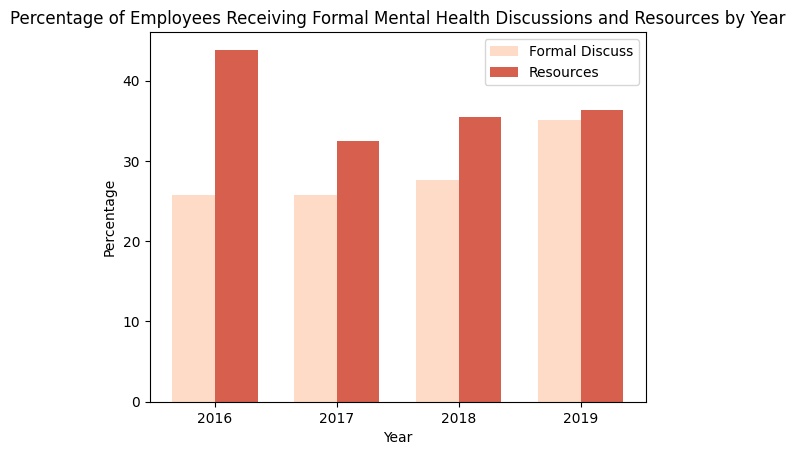

In [ ]:
#Question 15: Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
#Question 16: Does your employer offer resources to learn more about mental health disorders and options for seeking help?

query = """
SELECT year,
       (COUNT(discussed_MH)*100.0 / COUNT(*)) AS discussed_MH_Percentage,
              (COUNT(resources)*100.0 / COUNT(*)) AS resources_Percentage
FROM (
 SELECT UserID,SurveyID AS year,
        MAX(CASE WHEN (QuestionID == 4  AND AnswerText !=-1) THEN AnswerText END) AS state,
        MAX(CASE WHEN (QuestionID == 5  AND AnswerText != 1) THEN AnswerText END) AS Self_Employed,
        MAX(CASE WHEN (QuestionID == 13  AND AnswerText == 1) THEN AnswerText END) AS Tech_company,
        MAX(CASE WHEN (QuestionID == 15 AND AnswerText == 'Yes') THEN 1 END) AS discussed_MH,
        MAX(CASE WHEN (QuestionID == 16 AND AnswerText == 'Yes') THEN 1 END) AS resources,
        COUNT (*) as count

 FROM Answer
 WHERE   QuestionID IN (4,5,13,15,16)


GROUP BY UserID
HAVING state IS NOT NULL
       AND Self_Employed IS NOT NULL
       AND Tech_company IS NOT NULL
)
GROUP BY year

"""
df = pd.read_sql(query, con)

fig, ax = plt.subplots()
x = np.arange(len(df['year']))
width = 0.35
rects1 = ax.bar(x - width/2, df['discussed_MH_Percentage'], width, label='Formal Discuss', color = '#FDDBC7')
rects2 = ax.bar(x + width/2, df['resources_Percentage'], width, label='Resources', color = '#D6604D')

# Add labels and titles
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Employees Receiving Formal Mental Health Discussions and Resources by Year')
ax.set_xticks(x)
ax.set_xticklabels(df['year'])
ax.legend()

# Display the chart
plt.show()